# Labolatorium 5
## Zadanie obowiązkowe implementacja LSM, Ridge, Lasso
W zbadano techniki rekuraryzacji w modelach wielowymiarowych. Na podstawie danych produkcyjnych z rafinerii https://people.sc.fsu.edu/~jburkardt/datasets/regression/x18.txt zbudowane trzy modele: Least Mean Squares (model bez rekuraryzacji), Regresja Grzbietowa (Rigde Regression) i rekuraryzacja w normie L1 (Lasso Regression).

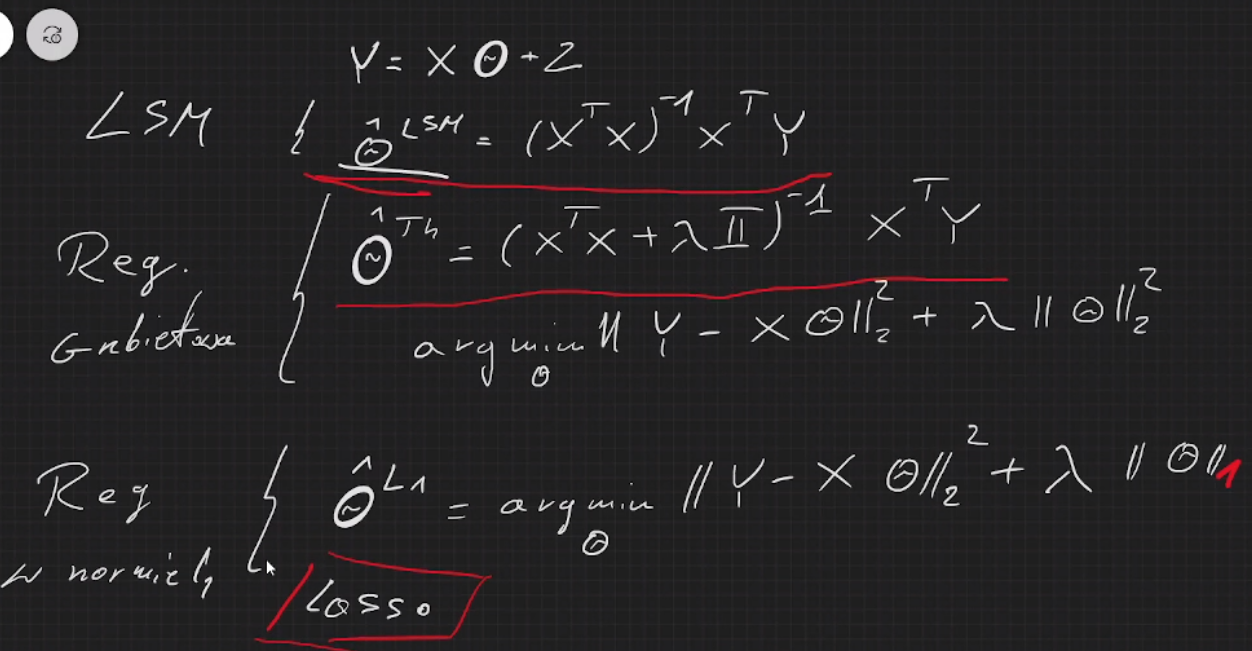

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso, Ridge, LinearRegression
from sklearn.metrics import mean_squared_error
import tqdm

Pobrane dane prezentują się następująco:

In [26]:
df = pd.read_csv('data.csv').drop(columns=['Index'])
df

,One,Material_1,Material_2,Material_3,Condition,Octanenumber
0,1,55.33,1.72,54,1.66219,92.19
1,1,59.13,1.20,53,1.58399,92.74
2,1,57.39,1.42,55,1.61731,91.88
3,1,56.43,1.78,55,1.66228,92.80
4,1,55.98,1.58,54,1.63195,92.56
...,...,...,...,...,...,...
77,1,67.60,1.84,55,1.64758,91.86
78,1,64.81,2.24,54,1.69592,91.61
79,1,63.13,1.60,52,1.66118,92.17
80,1,63.48,3.46,52,1.48216,91.56


In [27]:
X = np.array(df.drop(columns=['Octanenumber']))
Y = np.array(df['Octanenumber'])
I = np.identity(X.shape[1]) # macież jednostkowa (5x5)

In [28]:
def show_prediction(name, y_true, y_pred):
    order = np.argsort(y_true)
    plt.title(name)
    for y, label in zip([y_true, y_pred], ['y_true', 'y_pred']):
        plt.plot(np.arange(y_true.shape[0]), y, label=label)
    plt.legend()
    plt.show()

Pierwszym krokiem była implementacja tradycyjnego =algorytmu regresji metoda najmniejszych kwadratów (ang. Least Mean Squares LSM).

Współczynniki wyznaczone przez model LSM: [95.85315  -0.092821 -0.126798 -0.025381  1.967603]


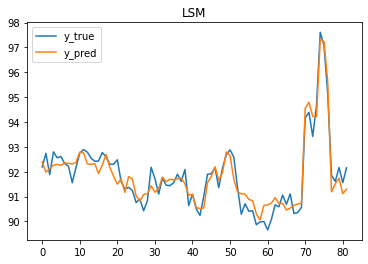

In [29]:
LSM = np.linalg.inv(X.T@X)@X.T@Y
np.set_printoptions(suppress=True)
print(f'Współczynniki wyznaczone przez model LSM: {np.around(LSM, 6)}')
LSM_Y_pred = np.sum(X*LSM, axis=1)
show_prediction('LSM', Y, LSM_Y_pred)

Współczynniki wyznaczone przez Ridge regression: [14.947625 -0.015277  0.660743  0.827951 18.824225]


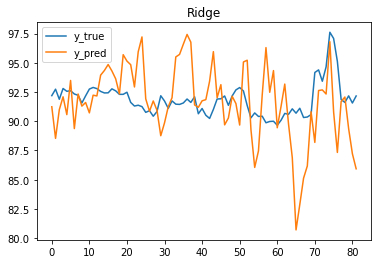

In [30]:
ridge_lambda = 1
model_ridge = np.linalg.inv(X.T@X+ridge_lambda*I)@X.T@Y
print(f'Współczynniki wyznaczone przez Ridge regression: {np.around(model_ridge, 6)}')
Ridge_Y_pred = np.sum(X*model_ridge, axis=1)
show_prediction('Ridge', Y, Ridge_Y_pred)

Współczynniki wyznaczone przez model Lasso: [ 0.       -0.092821 -0.126798 -0.025381  1.967603]


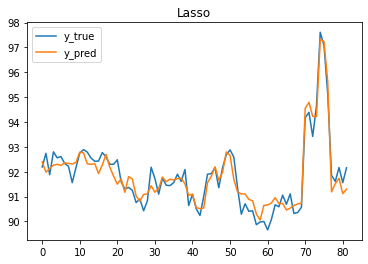

In [31]:
model_lasso = LinearRegression()
model_lasso.fit(X, Y)
print(f'Współczynniki wyznaczone przez model Lasso: {np.round(model_lasso.coef_,6)}')
show_prediction('Lasso', Y, model_lasso.predict(X))

## Wnioski do zadania pierwszego
W zadaniu celowo nie policzono metryk wydajności dla problemu regresji, ponieważ użyto całości danych do stworzenia modelu. Obserwując współczynniki wygenerowane przez modele można zauważyć, że w przypadku Ridge regression uzyskano mniejsze wartości niż dla regresji LSM. Zwiększając parametr lambda, współczynnik zbiegają do zera. W przypadku Lasso pierwszy współczynnik wynosi dokładnie 0, co jest spójne z ideą działania regularyzacji L1, ponieważ cecha ta nie jest informatywna (każdy rekord ma wartość 1)

## Własna analiza
Zbadano wpływ dodatkowych trzech nieinformatywnych cech na jakość predykcji. Dla uproszczenia kodu skorzystano z implementacji z biblioteki sklearn. Pierwsze 50 przykładów wzięto do treningu pozostałe do określenia błędu średniokwadratowego (ang. Mean Square Error MSE).

In [32]:
#Stworzenie nieinforamtywnych cech
junk_features = np.random.normal(1, 0.1, (X.shape[0], 100))
X_dirty = np.concatenate((X, junk_features), axis=1)
models = {
    "LSM": LinearRegression(),
    "Ridge": Ridge(),
    "Lasso": Lasso()
}

X_all = {
    "cech z bazy": X,
    "bazy z dodatkowymi cechami": X_dirty
}

for X_key in X_all:
    for model_key in models:
        models[model_key].fit(X_all[X_key][:50], Y[:50])
        mse = mean_squared_error(Y[50:], models[model_key].predict(X_all[X_key][50:]))
        print(f'{model_key} dla {X_key} MSE: {round(mse, 3)}')

LSM dla cech z bazy MSE: 0.343
Ridge dla cech z bazy MSE: 0.375
Lasso dla cech z bazy MSE: 1.827
LSM dla bazy z dodatkowymi cechami MSE: 0.563
Ridge dla bazy z dodatkowymi cechami MSE: 0.462
Lasso dla bazy z dodatkowymi cechami MSE: 1.827


## Wnioski (własny eksperyment)
Po dodaniu nadmiarowych (nieinformatywnych) cech do modelu  jakość predykcji modelu Lasso nie zmieniła się. Jest to zgodne z intuicją, ponieważ model ten wyzerowuje nieinformatywne cechy. MSE modelu Ridge pogorszył się nieznacznie w porównaniu do regresji liniowej, której przewidywania dla modelu z dodatkowymi cechami okazały się gorsze niż z zastosowaniem regresji grzbietowej.

In [41]:
junk_features_numbers = [1, 10, 100, 1000, 10000, 100000, 1000000, 10000000]
results = np.zeros((3, len(junk_features_numbers)))
for i, number in enumerate(tqdm.tqdm(junk_features_numbers)):
    junk_features = np.random.normal(1, 0.1, (X.shape[0], number))
    X_dirty = np.concatenate((X, junk_features), axis=1)
    for j, model in enumerate(models):
        models[model].fit(X_dirty[:50], Y[:50])
        results[j, i] = mean_squared_error(Y[50:], models[model].predict(X_dirty[50:]))

100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [03:35<00:00, 26.94s/it]


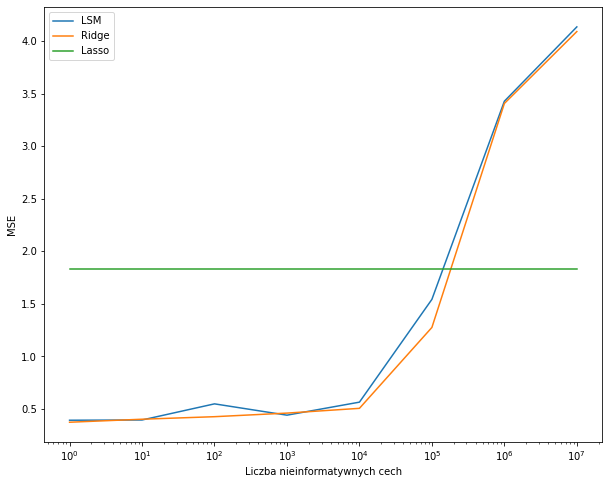

In [43]:

plt.figure(figsize=(10, 8))
for i, model in enumerate(models):
    plt.plot(junk_features_numbers, results[i], label=model)
plt.xscale("log")
plt.xlabel("Liczba nieinformatywnych cech")
plt.ylabel("MSE")
plt.legend()
plt.show()

Dodatkowo sprawdzono skuteczność modeli w zależności od liczby nieinformatywnych cech. Regularyzacja Lasso dzięki ich zerowaniu nie jest na nie podatna z tego powodu utrzymuje tą samą jakość predykcji, co przekłada się na uzyskanie najlepszych rezultatów dla większej ilości cech.